In [22]:
import redis
import json
import random
import numpy as np
import ast
import psycopg2
from psycopg2 import Error
import time
import matplotlib.pyplot as plt

In [15]:
redis_host = 'localhost'
redis_port = 6379
redis_password = ''

N = 1000
M = 1000
V = 500

In [3]:
r = redis.StrictRedis(host=redis_host,
                              port=redis_port,
                              password=redis_password,
                              charset="utf-8",
                              decode_responses=True)

In [4]:
def get_geotrack():
    track = []
    for n in range(M):
        track.append([random.uniform(0, 1000), random.uniform(0, 1000)])

    return track

def create_geotracks():
    geotracks = []
    for i in range(N):
        geotracks.append(get_geotrack())

    return geotracks

In [5]:
def add_redis_data(geotracks):
    for i, track in enumerate(geotracks):
        r.delete(f"arr_{i+1}")
        r.set(f"arr_{i+1}", json.dumps(track))

In [6]:
def get_redis_data():
    geotracks = []
    for i in range(N):
        geotracks.append(json.loads(r.get(f"arr_{i+1}")))

    return geotracks

In [7]:
def calculate_track_distance(track):
    ptdiff = lambda p1, p2: (p1[0]-p2[0], p1[1]-p2[1])
    diffs = (ptdiff(p1, p2) for p1, p2 in zip (track, track[1:]))
    return sum(np.hypot(*d) for d in  diffs)
    
def calculate_redis_data(tracks):
    distances = []
    for t in tracks:
        distances.append(calculate_track_distance(t))

    return distances

In [11]:
def get_values(geotracks):
    values = []
    for i, track in enumerate(geotracks):
        for points in track:
            values.append(str((i+1, points[0], points[1])))

    return ','.join(values)

In [12]:
 def add_postgres_data(values):
    try:
        connection = psycopg2.connect(user="postgres",
                                    password="postgres",
                                    host="127.0.0.1",
                                    port="5432",
                                    database="sudakov")

        cursor = connection.cursor()

        drop_tables_query = '''DROP TABLE IF EXISTS geotracks, points;'''

        cursor.execute(drop_tables_query)

        create_tables_query = '''Create table geotracks (
                                id SERIAL,
                                PRIMARY KEY(id)
                                );
                                
                                Create table points (
                                id SERIAL,
                                geotrack int REFERENCES geotracks(id),
                                x double precision,
                                y double precision,
                                PRIMARY KEY(id)
                                );'''

        cursor.execute(create_tables_query)


        add_geotracks_query = f'''INSERT INTO geotracks
                                    SELECT t
                                    FROM generate_series(0, {N}) as t(i);'''

        cursor.execute(add_geotracks_query)


        add_points_query = f'''INSERT INTO points(geotrack, x, y)
                                VALUES{values};'''

        cursor.execute(add_points_query)

        connection.commit()

    except (Exception, Error) as error:
        print("Ошибка при работе с PostgreSQL", error)
    finally:
        if connection:
            cursor.close()
            connection.close()
            print("Соединение с PostgreSQL закрыто")

In [13]:
def get_calculated_postgres_data():
    try:
        connection = psycopg2.connect(user="postgres",
                                    password="postgres",
                                    host="127.0.0.1",
                                    port="5432",
                                    database="sudakov")

        cursor = connection.cursor()

        get_lengths_query = '''SELECT geotrack1 as geotrack, sum(sqrt(pow(x1 - x2, 2)  + pow(y1 - y2, 2))) as len
                                FROM
                                (SELECT id, geotrack as geotrack1, x as x1, y as y1
                                FROM points p) t1
                                JOIN
                                (SELECT id, geotrack as geotrack2, x as x2, y as y2
                                FROM points p) t2
                                ON t1.geotrack1 = t2.geotrack2 AND t1.id = t2.id+1
                                GROUP BY geotrack
                                ORDER BY geotrack;'''

        cursor.execute(get_lengths_query)

        lengths = cursor.fetchall()

        connection.commit()

    except (Exception, Error) as error:
        print("Ошибка при работе с PostgreSQL", error)
    finally:
        if connection:
            cursor.close()
            connection.close()

    return lengths

In [14]:
def main():
    for n in range(V):
        geotracks = create_geotracks()
        add_redis_data(geotracks)
        add_postgres_data(get_values(geotracks))

        start = time.time()
        sums['redis'].append(calculate_redis_data(get_redis_data()))
        execution_time['redis'].append(time.time() - start)

        start = time.time()
        sums['sql'].append(list(map(lambda a: a[1], get_calculated_postgres_data())))
        execution_time['sql'].append(time.time() - start)
        
        print(n)

    return execution_time, sums

In [16]:
execution_time = {'redis': [], 'sql': []}
sums = {'redis': [], 'sql': []}
main()

Соединение с PostgreSQL закрыто
0
Соединение с PostgreSQL закрыто
1
Соединение с PostgreSQL закрыто
2
Соединение с PostgreSQL закрыто
3
Соединение с PostgreSQL закрыто
4
Соединение с PostgreSQL закрыто
5
Соединение с PostgreSQL закрыто
6
Соединение с PostgreSQL закрыто
7
Соединение с PostgreSQL закрыто
8
Соединение с PostgreSQL закрыто
9
Соединение с PostgreSQL закрыто
10
Соединение с PostgreSQL закрыто
11
Соединение с PostgreSQL закрыто
12
Соединение с PostgreSQL закрыто
13
Соединение с PostgreSQL закрыто
14
Соединение с PostgreSQL закрыто
15
Соединение с PostgreSQL закрыто
16
Соединение с PostgreSQL закрыто
17
Соединение с PostgreSQL закрыто
18
Соединение с PostgreSQL закрыто
19
Соединение с PostgreSQL закрыто
20
Соединение с PostgreSQL закрыто
21
Соединение с PostgreSQL закрыто
22
Соединение с PostgreSQL закрыто
23
Соединение с PostgreSQL закрыто
24
Соединение с PostgreSQL закрыто
25
Соединение с PostgreSQL закрыто
26
Соединение с PostgreSQL закрыто
27
Соединение с PostgreSQL закрыт

KeyboardInterrupt: 

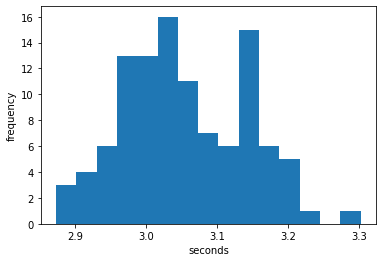

In [32]:
plt.hist(execution_time['redis'], bins = 15)
plt.xlabel('seconds')
plt.ylabel('frequency')
plt.show()

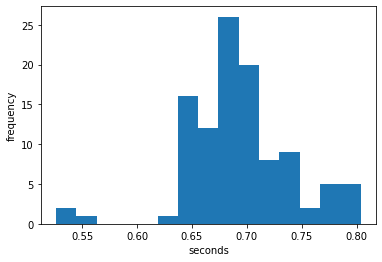

In [33]:
plt.hist(execution_time['sql'], bins = 15)
plt.xlabel('seconds')
plt.ylabel('frequency')
plt.show()

In [30]:
print('Mean: ', np.mean(np.array(execution_time['redis'])))
print('Dispersion: ', np.std(np.array(execution_time['redis'])))

Mean:  3.0539907874348007
Dispersion:  0.08571594402705891


In [31]:
print('Mean: ', np.mean(np.array(execution_time['sql'])))
print('Dispersion: ', np.std(np.array(execution_time['sql'])))

Mean:  0.6942332949593802
Dispersion:  0.04789285498907946
